# Comparison of Gradient Boosting Regressor on predicting elastic moduli G and K

In this notebook, performance of de Jong based featurization with Gradient Boosting Regressor model on G and K is evaluated. The compounds are partitioned into unary, binary and ternary compounds. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

### Load featurized data

In [2]:
data = pd.read_pickle('./dejong_featurized_data.pkl')

Partition data into unary, binary, ternary and quarternary compounds

In [3]:
data['k-nary'] = data['composition'].apply(lambda x: len(x))

Fill in NaN values and shuffle data

In [4]:
data.fillna(value=0.0, inplace=True)
data = shuffle(data)

Input X and y

In [5]:
x = data.drop(['material_id', 'volume', 'elastic_anisotropy', 'G_VRH', 
               'K_VRH', 'poisson_ratio', 'structure', 'composition', 
               'k-nary'], 1)
y = {'K': np.log(data['K_VRH']), 'G': np.log(data['G_VRH'])}

Save k-nary data for later use

In [6]:
k_nary = data['k-nary']
k_nary_test = k_nary[int(data.shape[0]*0.8):]

Separate data into training and testing data
(80% training and 20% testing)

In [7]:
x_train, x_test = x[:int(data.shape[0]*0.8)], x[int(data.shape[0]*0.8):]
y_train = {'K': y['K'][:int(data.shape[0]*0.8)], 'G': y['G'][:int(data.shape[0]*0.8)]}
y_test = {'K': y['K'][int(data.shape[0]*0.8):], 'G': y['G'][int(data.shape[0]*0.8):]}

In [8]:
y_pred = {'K': None, 'G': None}

## Build ML model

Train data using best algorithm in `DeJong_02_prediction.ipynb`, which is Gradient Boosting Regressor.

##### K (bulk modulus) 

In [9]:
%%time
gradient_K = GradientBoostingRegressor(n_estimators=500, max_depth=3)
gradient_K.fit(x_train, y_train['K'])

CPU times: user 5.91 s, sys: 56 ms, total: 5.96 s
Wall time: 6.17 s


In [10]:
y_pred['K'] = gradient_K.predict(x_test)

Calculate the errors of prediction

In [11]:
mae_K = mean_absolute_error(y_test['K'], y_pred['K'])
rmse_K = np.sqrt(mean_squared_error(y_test['K'], y_pred['K']))
r2_K = r2_score(y_test['K'], y_pred['K'])

##### G (shear modulus) 

In [12]:
%%time
gradient_G = GradientBoostingRegressor(n_estimators=500, max_depth=3)
gradient_G.fit(x_train, y_train['G'])

CPU times: user 5.75 s, sys: 43.1 ms, total: 5.8 s
Wall time: 5.93 s


In [13]:
y_pred['G'] = gradient_G.predict(x_test)

Calculate the errors of prediction

In [14]:
mae_G = mean_absolute_error(y_test['G'], y_pred['G'])
rmse_G = np.sqrt(mean_squared_error(y_test['G'], y_pred['G']))
r2_G = r2_score(y_test['G'], y_pred['G'])

Plot the predictions

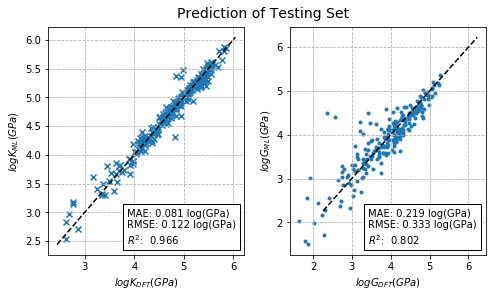

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle("Prediction of Testing Set", fontsize=14, x=0.53, y=1.02)

ax1.set_xlabel("$log K_{DFT} (GPa)$")
ax1.set_ylabel("$log K_{ML} (GPa)$")

ax1.scatter(y_test['K'], y_pred['K'], marker='x')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.text(0.4, 0.05, 
         'MAE: {:.3f} log(GPa)\nRMSE: {:.3f} log(GPa)\n$R^2$:  {:.3f}'.format(mae_K, rmse_K, r2_K),
         transform=ax1.transAxes,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax1.grid(True, linestyle='--')

ax2.set_xlabel("$log G_{DFT} (GPa)$")
ax2.set_ylabel("$log G_{ML} (GPa)$")

ax2.scatter(y_test['G'], y_pred['G'], marker='.')
ax2.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax2.text(0.4, 0.05, 
         'MAE: {:.3f} log(GPa)\nRMSE: {:.3f} log(GPa)\n$R^2$:  {:.3f}'.format(mae_G, rmse_G, r2_G),
         transform=ax2.transAxes,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.grid(True, linestyle='--')

fig.set_size_inches(7, 4)
fig.tight_layout()

Calculate root-mean-squared error (RMSE) over 10 fold cross validation loop

In [16]:
RMSE_K = np.sqrt(np.abs(cross_val_score(GradientBoostingRegressor(n_estimators=500, max_depth=3), x, y['K'], cv=KFold(10, shuffle=True), scoring='neg_mean_squared_error')))
RMSE_G = np.sqrt(np.abs(cross_val_score(GradientBoostingRegressor(n_estimators=500, max_depth=3), x, y['G'], cv=KFold(10, shuffle=True), scoring='neg_mean_squared_error')))
print ("RMSE of K: ", RMSE_K.mean(), "log (GPa)")
print ("RMSE of G: ", RMSE_G.mean(), "log (GPa)")

RMSE of K:  0.13741566681255377 log (GPa)
RMSE of G:  0.2728339818781354 log (GPa)


*Finding*: As compared to RMSE in the paper (0.0750 for log K and 0.1378 for log G (GPa)), our RMSE are in the same magnitude but still larger.

### Plot showing prediction performance of model on unary, binary and ternary compounds

So here a dictionary is initialized to partition compounds into their respective k-nary groups.

In [17]:
K_test = {1:[], 2:[], 3:[], 4:[]}
K_pred = {1:[], 2:[], 3:[], 4:[]}

G_test = {1:[], 2:[], 3:[], 4:[]}
G_pred = {1:[], 2:[], 3:[], 4:[]}

In [18]:
k_nary_test = k_nary_test.reset_index(drop=True)
y_test['K'] = y_test['K'].reset_index(drop=True)
y_test['G'] = y_test['G'].reset_index(drop=True)

Partitioning the compounds

In [19]:
for i in range(k_nary_test.shape[0]):
    K_test[k_nary_test[i]].append(y_test['K'][i])
    K_pred[k_nary_test[i]].append(y_pred['K'][i])
    
    G_test[k_nary_test[i]].append(y_test['G'][i])
    G_pred[k_nary_test[i]].append(y_pred['G'][i])

Plot the predictions (Our dataset consists of 19 unary, 169 binary, 49 ternary and 0 quarternary compounds)

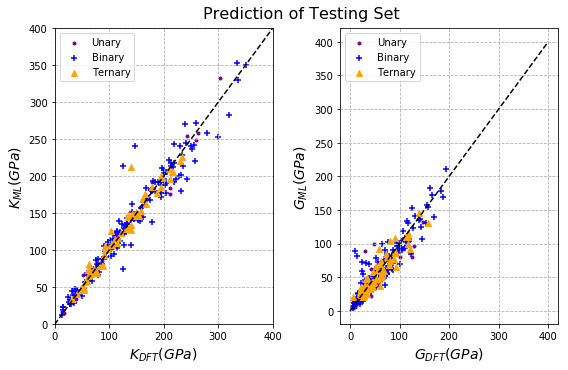

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle("Prediction of Testing Set", fontsize=16, x=0.53, y=1.02)

ax1.set_xlabel("$K_{DFT} (GPa)$", fontsize=14)
ax1.set_ylabel("$K_{ML} (GPa)$", fontsize=14)
ax1.set_xlim(right=400)
ax1.set_ylim(top=400)

ax1.scatter(np.exp(K_test[1]), np.exp(K_pred[1]), color='purple', marker='.', label='Unary')
ax1.scatter(np.exp(K_test[2]), np.exp(K_pred[2]), color='blue', marker='+', label='Binary')
ax1.scatter(np.exp(K_test[3]), np.exp(K_pred[3]), color='orange', marker='^', label='Ternary')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax1.legend()
ax1.grid(True, linestyle='--')

ax2.set_xlabel("$G_{DFT} (GPa)$", fontsize=14)
ax2.set_ylabel("$G_{ML} (GPa)$", fontsize=14)

ax2.scatter(np.exp(G_test[1]), np.exp(G_pred[1]), color='purple', marker='.', label='Unary')
ax2.scatter(np.exp(G_test[2]), np.exp(G_pred[2]), color='blue', marker='+', label='Binary')
ax2.scatter(np.exp(G_test[3]), np.exp(G_pred[3]), color='orange', marker='^', label='Ternary')
ax2.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax2.legend()
ax2.grid(True, linestyle='--')

fig.set_size_inches(8, 5)
fig.tight_layout()

*Finding*: We don't have quarternary compounds. Prediction of ternary compound is generally better.